In [1]:
from getpass import getuser # Libaray to copy things
from tempfile import NamedTemporaryFile, TemporaryDirectory 

import dask
from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="100GB"
)
client 

# calculation
import metpy.calc as mpcalc

# scipy
from scipy import stats
from scipy.ndimage import measurements
from scipy import ndimage
from scipy.optimize import curve_fit

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# basic
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import netCDF4 as nc
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data

# dask
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

Number of CPUs: 256, number of threads: 8, number of workers: 32


2024-11-06 15:41:52,192 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-ejtwdg16', purging
2024-11-06 15:41:52,199 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-2l4yf9fy', purging
2024-11-06 15:41:52,210 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-66mskljn', purging
2024-11-06 15:41:52,216 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-6hh8jzjn', purging
2024-11-06 15:41:52,225 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-9_mbcs8c', purging
2024-11-06 15:41:52,232 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Pro

In [2]:
import sys
sys.path.append('/home/m/m300948/ICON_AMZDEF')
import Tools

Number of CPUs: 256, number of threads: 8, number of workers: 32


# Load data

In [3]:
# Define the date string
date = "2022" + "*"

In [4]:
# precipitation (30 mins) kg m-2 s-1
pr_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/pr/ctl_daily_pr_' + date, parallel=True)['pr']
pr_def = xr.open_mfdataset('/scratch/m/m300948/def_100/pr/def_daily_pr_' + date, parallel=True)['pr']

In [5]:
# taecipitation (30 mins) kg m-2 s-1
tas_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/2mt/ctl_daily_tas_' + date, parallel=True)['tas']
tas_def = xr.open_mfdataset('/scratch/m/m300948/def_100/2mt/def_daily_tas_' + date, parallel=True)['tas']

In [5]:
# vertical wind (15 levels, 6 hours) m s-1 (should be converted to Pa s-1)
wa_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/3d/vertical_w/ctl_daily_wa_plev_'+ f'{date}',parallel=True)['wa']
wa_def = xr.open_mfdataset('/scratch/m/m300948/def_100/3d/vertical_w/def_daily_wa_plev_'+ f'{date}',parallel=True)['wa']

In [ ]:
# vertical wind (15 levels, 6 hours) m s-1 (should be converted to Pa s-1)
q_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/3d/specif_humidity/6hourly/ctl_daily_hus_plev_'+ f'{date}',parallel=True)['hus']
q_def = xr.open_mfdataset('/scratch/m/m300948/def_100/3d/specif_humidity/6hourly/def_daily_hus_plev_'+ f'{date}',parallel=True)['hus']

In [7]:
# total column water vapor (kg m-2)
prw_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/prw/ctl_daily_prw_'+ f'{date}',parallel=True)['prw']
prw_def = xr.open_mfdataset('/scratch/m/m300948/def_100/prw/def_daily_prw_'+ f'{date}',parallel=True)['prw']

In [6]:
# Variables modify
hfls_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/hfls/ctl_daily_hfls_'+ f'{date}',parallel=True)['hfls']
hfls_def = xr.open_mfdataset('/scratch/m/m300948/def_100/hfls/def_daily_hfls_'+ f'{date}',parallel=True)['hfls']

In [7]:
ev_ctl = hfls_ctl/28.94
ev_def = hfls_def/28.94

In [8]:
pr_ctl_amz = pr_ctl.sel(lon=slice(-80,-40), lat=slice(-20,10))
pr_def_amz = pr_def.sel(lon=slice(-80,-40), lat=slice(-20,10))

In [8]:
tas_ctl_amz = tas_ctl.sel(lon=slice(-80,-40), lat=slice(-20,10))
tas_def_amz = tas_def.sel(lon=slice(-80,-40), lat=slice(-20,10))

In [9]:
wa_ctl_amz = wa_ctl.sel(lon=slice(-80,-40), lat=slice(-20,10))
wa_def_amz = wa_def.sel(lon=slice(-80,-40), lat=slice(-20,10))

In [11]:
prw_ctl_amz = prw_ctl.sel(lon=slice(-80,-40), lat=slice(-20,10))
prw_def_amz = prw_def.sel(lon=slice(-80,-40), lat=slice(-20,10))

In [11]:
ev_ctl_amz = ev_ctl.sel(lon=slice(-80,-40), lat=slice(-20,10))
ev_def_amz = ev_def.sel(lon=slice(-80,-40), lat=slice(-20,10))

In [12]:
import numpy as np
# Round the longitude values in the extreme_pr_expanded_ctl dataset
pr_ctl_amz['lon'] = np.round(pr_ctl_amz['lon'], 2)
pr_def_amz['lon'] = np.round(pr_def_amz['lon'], 2)

# Round the longitude values in the extreme_pr_expanded_ctl dataset
wa_ctl_amz['lon'] = np.round(wa_ctl_amz['lon'], 2)
wa_def_amz['lon'] = np.round(wa_def_amz['lon'], 2)

#prw_ctl_amz['lon'] = np.round(prw_ctl_amz['lon'], 2)
#prw_def_amz['lon'] = np.round(prw_def_amz['lon'], 2)

#tas_ctl_amz['lon'] = np.round(tas_ctl_amz['lon'], 2)
#tas_def_amz['lon'] = np.round(tas_def_amz['lon'], 2)

ev_ctl_amz['lon'] = np.round(ev_ctl_amz['lon'], 2)
ev_def_amz['lon'] = np.round(ev_def_amz['lon'], 2)

In [13]:
import numpy as np
# Round the latgitude values in the extreme_pr_expanded_ctl dataset
pr_ctl_amz['lat'] = np.round(pr_ctl_amz['lat'], 2)
pr_def_amz['lat'] = np.round(pr_def_amz['lat'], 2)

# Round the latgitude values in the extreme_pr_expanded_ctl dataset
wa_ctl_amz['lat'] = np.round(wa_ctl_amz['lat'], 2)
wa_def_amz['lat'] = np.round(wa_def_amz['lat'], 2)

#prw_ctl_amz['lat'] = np.round(prw_ctl_amz['lat'], 2)
#prw_def_amz['lat'] = np.round(prw_def_amz['lat'], 2)

#tas_ctl_amz['lat'] = np.round(tas_ctl_amz['lat'], 2)
#tas_def_amz['lat'] = np.round(tas_def_amz['lat'], 2)

ev_ctl_amz['lat'] = np.round(ev_ctl_amz['lat'], 2)
ev_def_amz['lat'] = np.round(ev_def_amz['lat'], 2)

In [14]:
dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
AMZ_BD = dset_bd.AMAZON_BIOMES

In [15]:
ABinterp_biome_ctl = AMZ_BD.interp(latitude=wa_ctl_amz.lat, longitude=wa_ctl_amz.lon)

In [16]:
pr_ctl_mask = pr_ctl_amz.where(ABinterp_biome_ctl == 0, np.nan)
pr_def_mask = pr_def_amz.where(ABinterp_biome_ctl == 0, np.nan)

In [17]:
wa_ctl_mask = wa_ctl_amz.where(ABinterp_biome_ctl == 0, np.nan)
wa_def_mask = wa_def_amz.where(ABinterp_biome_ctl == 0, np.nan)

In [18]:
tas_ctl_mask = tas_ctl_amz.where(ABinterp_biome_ctl == 0, np.nan)
tas_def_mask = tas_def_amz.where(ABinterp_biome_ctl == 0, np.nan)

In [19]:
prw_ctl_mask = prw_ctl_amz.where(ABinterp_biome_ctl == 0, np.nan)
prw_def_mask = prw_def_amz.where(ABinterp_biome_ctl == 0, np.nan)

In [18]:
ev_ctl_mask = ev_ctl_amz.where(ABinterp_biome_ctl == 0, np.nan)
ev_def_mask = ev_def_amz.where(ABinterp_biome_ctl == 0, np.nan)

In [20]:
# select every 6n hour instantenous precipitation
pr_ctl_7n = pr_ctl_mask.loc[pr_ctl_mask.time.dt.hour.isin([0, 6, 12, 18]) & (pr_ctl_mask.time.dt.minute == 0)] *3600
pr_def_7n = pr_def_mask.loc[pr_def_mask.time.dt.hour.isin([0, 6, 12, 18]) & (pr_def_mask.time.dt.minute == 0)] *3600

In [21]:
# intense precipitation for each grid point
intense_pr_mask_ctl_7n = pr_ctl_7n.where(pr_ctl_7n > 50)
intense_pr_mask_def_7n = pr_def_7n.where(pr_def_7n > 50)
extreme_pr_mask_ctl = pr_ctl_7n > 50 # true/false 
extreme_pr_mask_def = pr_def_7n > 50 

In [22]:
# select the wa when intense precipitation
selected_wa_ctl= wa_ctl_mask.where(extreme_pr_mask_ctl)
selected_wa_def= wa_def_mask.where(extreme_pr_mask_def)

In [23]:
# select the tas when intense precipitation
selected_tas_ctl= tas_ctl_mask.where(extreme_pr_mask_ctl)
selected_tas_def= tas_def_mask.where(extreme_pr_mask_def)

In [24]:
# select the wa when intense precipitation
selected_prw_ctl= prw_ctl_mask.where(extreme_pr_mask_ctl)
selected_prw_def= prw_def_mask.where(extreme_pr_mask_def)

In [25]:
# Step 1: Flatten all datasets to 1D and remove NaN values
U_diff_flat = selected_wa_ctl.sel(plev=50000).values.flatten() 
TCW_flat = selected_prw_ctl.sel(time=selected_wa_ctl.time).values.flatten()
Precip_flat = intense_pr_mask_ctl_7n.sel(time=selected_wa_ctl.time).values.flatten()

In [26]:
# Step 1: Flatten all datasets to 1D and remove NaN values
U_diff_flat_def = selected_wa_def.sel(plev=50000).values.flatten() 
TCW_flat_def = selected_prw_def.sel(time=selected_wa_def.time).values.flatten()
Precip_flat_def = intense_pr_mask_def_7n.sel(time=selected_wa_def.time).values.flatten()

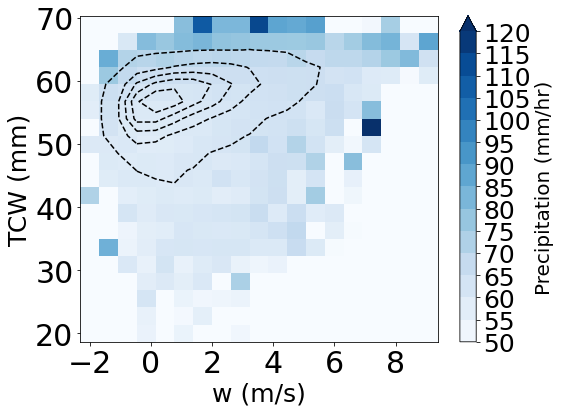

In [34]:
# Step 2: Mask to remove any NaN values in any of the three datasets
mask = ~np.isnan(U_diff_flat) & ~np.isnan(TCW_flat) & ~np.isnan(Precip_flat)

U_diff_clean = U_diff_flat[mask]
TCW_clean = TCW_flat[mask]
Precip_clean = Precip_flat[mask]

# Step 3: Create 2D histogram binning the TCW and U_diff, using precipitation as color
# ctline number of bins for x and y (TCW and U_diff)
x_bins = np.linspace(np.nanmin(U_diff_clean), np.nanmax(U_diff_clean), 20)  # Adjust bin size if needed
y_bins = np.linspace(np.nanmin(TCW_clean), np.nanmax(TCW_clean), 20)

# Create 2D histogram for binned precipitation data
precip_2d, x_edges, y_edges = np.histogram2d(U_diff_clean, TCW_clean, bins=[x_bins, y_bins], weights=Precip_clean)

# Count the number of data points in each bin (to avoid dividing by zero)
counts, _, _ = np.histogram2d(U_diff_clean, TCW_clean, bins=[x_bins, y_bins])

# Avoid division by zero by replacing zeros in counts with NaNs
avg_precip = precip_2d / counts
avg_precip[np.isnan(avg_precip)] = 0  # Replace NaNs with 0 if needed
#avg_precip[avg_precip < 50] = np.nan

# Step 4: Plot using pcolormesh
plt.figure(figsize=(8, 6))

# Plot the 2D grid with colors representing precipitation
plt.pcolormesh(x_edges, y_edges, avg_precip.T, shading='auto', cmap='Blues', vmin=50, vmax=120)
bounds = np.linspace(50, 120, 15)
cbar = plt.colorbar(extend='max', ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Precipitation (mm/hr)', fontsize=20)

# Set custom contour levels
custom_contour_levels = np.linspace(100, 2000, 5)  # Define your desired contour levels

# Plot contour lines for the counts (frequency of W and TCW)
plt.contour(x_edges[:-1], y_edges[:-1], counts.T, levels=custom_contour_levels, colors='black', linewidths=1.5, linestyles='--')

# Set axis labels
plt.xlabel('w (m/s)', fontsize=25)
plt.ylabel('TCW (mm)', fontsize=25)
#plt.title('Precipitation Based on U600-U925 and TCW', fontsize=14)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.show()

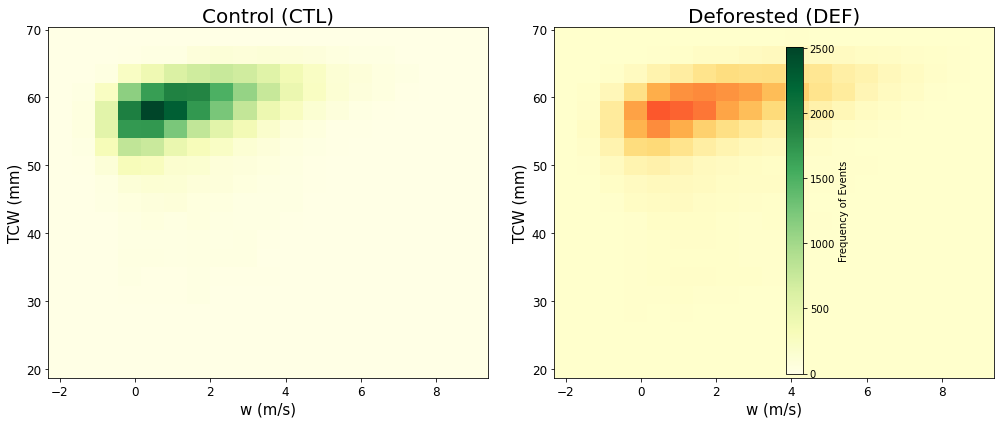

In [61]:
# Step 2: Mask to remove any NaN values in any of the three datasets
mask_ctl = ~np.isnan(U_diff_flat) & ~np.isnan(TCW_flat) & ~np.isnan(Precip_flat)
mask_def = ~np.isnan(U_diff_flat_def) & ~np.isnan(TCW_flat_def) & ~np.isnan(Precip_flat_def)

U_diff_clean_ctl = U_diff_flat[mask_ctl]
TCW_clean_ctl = TCW_flat[mask_ctl]
Precip_clean_ctl = Precip_flat[mask_ctl]

U_diff_clean_def = U_diff_flat_def[mask_def]
TCW_clean_def = TCW_flat_def[mask_def]
Precip_clean_def = Precip_flat_def[mask_def]

# Step 3: Create a 2D histogram binning the TCW and U_diff, based on event frequency
# Define number of bins for x (U_diff) and y (TCW)
x_bins = np.linspace(np.nanmin(U_diff_clean_ctl), np.nanmax(U_diff_clean_ctl), 20)
y_bins = np.linspace(np.nanmin(TCW_clean_ctl), np.nanmax(TCW_clean_ctl), 20)

# Create 2D histogram counting the number of events in each bin
counts_ctl, x_edges_ctl, y_edges_ctl = np.histogram2d(U_diff_clean_ctl, TCW_clean_ctl, bins=[x_bins, y_bins])
counts_def, x_edges_def, y_edges_def = np.histogram2d(U_diff_clean_def, TCW_clean_def, bins=[x_bins, y_bins])

# Optional: Apply a condition to only count bins where precipitation is above a threshold, e.g., 50 mm/hr
precip_threshold = 0
precip_above_threshold_ctl = Precip_clean_ctl >= precip_threshold
precip_above_threshold_def = Precip_clean_def >= precip_threshold

frequency_2d_ctl, _, _ = np.histogram2d(U_diff_clean_ctl[precip_above_threshold_ctl], TCW_clean_ctl[precip_above_threshold_ctl], bins=[x_bins, y_bins])
frequency_2d_def, _, _ = np.histogram2d(U_diff_clean_def[precip_above_threshold_def], TCW_clean_def[precip_above_threshold_def], bins=[x_bins, y_bins])

# Avoid division by zero by replacing zeros in counts with NaNs
frequency_2d_ctl[np.isnan(frequency_2d_ctl)] = 0  # Replace NaNs with 0 if needed
frequency_2d_def[np.isnan(frequency_2d_def)] = 0  # Replace NaNs with 0 if needed

# Define common vmin and vmax for colorbars
vmin = 0
vmax = max(np.nanmax(frequency_2d_ctl), np.nanmax(frequency_2d_def))

# Step 4: Plot side by side using subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the 2D grid with colors representing frequency of events for control (CTL)
c1 = ax[0].pcolormesh(x_edges_ctl, y_edges_ctl, frequency_2d_ctl.T, shading='auto', cmap='YlGn', vmin=vmin, vmax=vmax)
ax[0].set_title('Control (CTL)', fontsize=20)
ax[0].set_xlabel('w (m/s)', fontsize=15)
ax[0].set_ylabel('TCW (mm)', fontsize=15)

# Plot the 2D grid with colors representing frequency of events for deforested (DEF)
c2 = ax[1].pcolormesh(x_edges_def, y_edges_def, frequency_2d_def.T, shading='auto', cmap='YlOrRd', vmin=vmin, vmax=vmax)
ax[1].set_title('Deforested (DEF)', fontsize=20)
ax[1].set_xlabel('w (m/s)', fontsize=15)
ax[1].set_ylabel('TCW (mm)', fontsize=15)

# Add a single colorbar for both plots, spanning the entire figure
fig.colorbar(c1, ax=ax, orientation='vertical', label='Frequency of Events')

# Set tick size for both plots
for axis in ax:
    axis.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

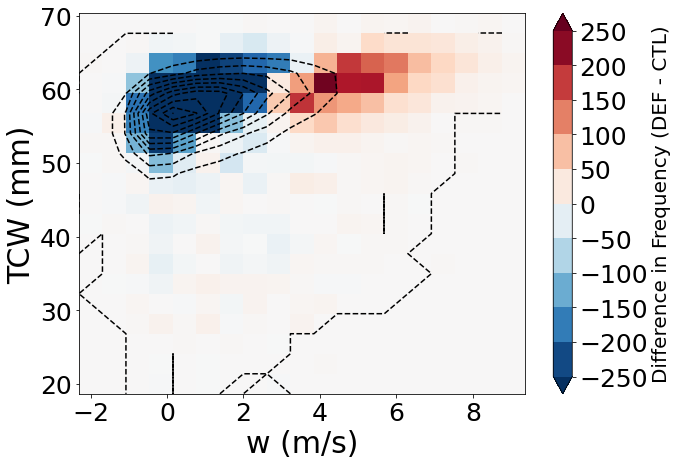

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Mask to remove any NaN values in any of the three datasets
mask_ctl = ~np.isnan(U_diff_flat) & ~np.isnan(TCW_flat) & ~np.isnan(Precip_flat)
mask_def = ~np.isnan(U_diff_flat_def) & ~np.isnan(TCW_flat_def) & ~np.isnan(Precip_flat_def)

U_diff_clean_ctl = U_diff_flat[mask_ctl]
TCW_clean_ctl = TCW_flat[mask_ctl]
Precip_clean_ctl = Precip_flat[mask_ctl]

U_diff_clean_def = U_diff_flat_def[mask_def]
TCW_clean_def = TCW_flat_def[mask_def]
Precip_clean_def = Precip_flat_def[mask_def]

# Step 3: Create a 2D histogram binning the TCW and U_diff, based on event frequency
x_bins = np.linspace(np.nanmin(U_diff_clean_ctl), np.nanmax(U_diff_clean_ctl), 20)
y_bins = np.linspace(np.nanmin(TCW_clean_ctl), np.nanmax(TCW_clean_ctl), 20)

# Create 2D histograms counting the number of events in each bin
counts_ctl, x_edges_ctl, y_edges_ctl = np.histogram2d(U_diff_clean_ctl, TCW_clean_ctl, bins=[x_bins, y_bins])
counts_def, x_edges_def, y_edges_def = np.histogram2d(U_diff_clean_def, TCW_clean_def, bins=[x_bins, y_bins])

# Calculate the difference between DEF and CTL
counts_diff = counts_def - counts_ctl

# Step 4: Plot the difference using a diverging color map (RdBu)
plt.figure(figsize=(10, 7))

# Plot the difference between DEF and CTL
m = plt.pcolormesh(x_edges_ctl, y_edges_ctl, counts_diff.T, shading='auto', cmap='RdBu_r', vmin=-250, vmax=250 ) #vmin=-np.max(np.abs(counts_diff)), vmax=np.max(np.abs(counts_diff)))

# Optional: Overlay contours for CTL to provide reference points
plt.contour(x_edges_ctl[:-1], y_edges_ctl[:-1], counts_ctl.T, levels=10, colors='black', linewidths=1.5, linestyles='--')

# Add a colorbar for the difference plot
# Add colorbar for precipitation
bounds = np.linspace(-250, 250, 11)
cbar = plt.colorbar(m, extend='both', ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Difference in Frequency (DEF - CTL)', fontsize=20)

# Set axis labels
plt.xlabel('w (m/s)', fontsize=30)
plt.ylabel('TCW (mm)', fontsize=30)

# Set tick size for the plot
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()


_2m temperature and vertical wind at 500 hPa_

In [28]:
# Step 1: Flatten all datasets to 1D and remove NaN values
U_diff_flat_ctl = selected_wa_ctl.sel(plev=50000).values.flatten() 
T2M_flat_ctl = selected_tas_ctl.sel(time=selected_wa_ctl.time).values.flatten()
Precip_flat_ctl = intense_pr_mask_ctl_7n.sel(time=selected_wa_ctl.time).values.flatten()

2024-09-23 17:25:44,607 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33371
Traceback (most recent call last):
  File "/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/distributed/comm/tcp.py", line 264, in write
    async def write(self, msg, serializers=None, on_error="message"):
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/asyncio/tasks.py", line 452, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/distributed/comm/core.py", line 327, in connect
    await asyncio.wait_for(comm.write(local_info), time_left())
  File "/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/pytho

In [29]:
# Step 1: Flatten all datasets to 1D and remove NaN values
U_diff_flat_def = selected_wa_def.sel(plev=50000).values.flatten() 
T2M_flat_def = selected_tas_def.sel(time=selected_wa_def.time).values.flatten()
Precip_flat_def = intense_pr_mask_def_7n.sel(time=selected_wa_def.time).values.flatten()

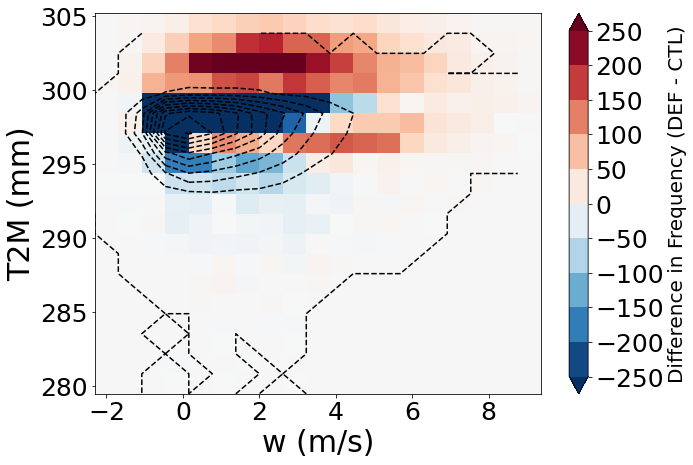

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Mask to remove any NaN values in any of the three datasets
mask_ctl = ~np.isnan(U_diff_flat_ctl) & ~np.isnan(T2M_flat_ctl) & ~np.isnan(Precip_flat_ctl)
mask_def = ~np.isnan(U_diff_flat_def) & ~np.isnan(T2M_flat_def) & ~np.isnan(Precip_flat_def)

U_diff_clean_ctl = U_diff_flat_ctl[mask_ctl]
T2M_clean_ctl = T2M_flat_ctl[mask_ctl]
Precip_clean_ctl = Precip_flat_ctl[mask_ctl]

U_diff_clean_def = U_diff_flat_def[mask_def]
T2M_clean_def = T2M_flat_def[mask_def]
Precip_clean_def = Precip_flat_def[mask_def]

# Step 3: Create a 2D histogram binning the T2M and U_diff, based on event frequency
x_bins = np.linspace(np.nanmin(U_diff_clean_ctl), np.nanmax(U_diff_clean_ctl), 20)
y_bins = np.linspace(np.nanmin(T2M_clean_ctl), np.nanmax(T2M_clean_ctl), 20)

# Create 2D histograms counting the number of events in each bin
counts_ctl, x_edges_ctl, y_edges_ctl = np.histogram2d(U_diff_clean_ctl, T2M_clean_ctl, bins=[x_bins, y_bins])
counts_def, x_edges_def, y_edges_def = np.histogram2d(U_diff_clean_def, T2M_clean_def, bins=[x_bins, y_bins])

# Calculate the difference between DEF and CTL
counts_diff = counts_def - counts_ctl

# Step 4: Plot the difference using a diverging color map (RdBu)
plt.figure(figsize=(10, 7))

# Plot the difference between DEF and CTL
m = plt.pcolormesh(x_edges_ctl, y_edges_ctl, counts_diff.T, shading='auto', cmap='RdBu_r', vmin=-250, vmax=250 ) #vmin=-np.max(np.abs(counts_diff)), vmax=np.max(np.abs(counts_diff)))

# Optional: Overlay contours for CTL to provide reference points
plt.contour(x_edges_ctl[:-1], y_edges_ctl[:-1], counts_ctl.T, levels=10, colors='black', linewidths=1.5, linestyles='--')

# Add a colorbar for the difference plot
# Add colorbar for precipitation
bounds = np.linspace(-250, 250, 11)
cbar = plt.colorbar(m, extend='both', ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Difference in Frequency (DEF - CTL)', fontsize=20)

# Set axis labels
plt.xlabel('w (m/s)', fontsize=30)
plt.ylabel('T2M (mm)', fontsize=30)

# Set tick size for the plot
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()


## 2d Map of vertical velocity

In [19]:
def contourf(data_w, data_c, vmin_w, vmax_w, color_steps, vmin_c, vmax_c, steps, cmap, extend, title, factor=9):
    fig = plt.figure(figsize=[8,10], facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    ax.set_extent([-80, -40, -19, 10])
    ax.coastlines('50m', linewidth=0.8)
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                      xlocs=range(-180, 180, 20), ylocs=range(-90, 90, 10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False

    # define lat and lon for data_w (original resolution)
    lats = data_w.lat
    lons = data_w.lon

    # Plot the high-resolution data_w using pcolormesh
    m = ax.pcolormesh(lons, lats, data_w, cmap=cmap, vmin=vmin_w, vmax=vmax_w, transform=ccrs.PlateCarree())

    # Reduce the resolution of data_c using the coarsen method
    data_c_coarse = data_c.coarsen(lat=factor, lon=factor, boundary='trim').mean()

    # Plot the lower-resolution data_c using contour
    c = ax.contour(data_c_coarse.lon, data_c_coarse.lat, data_c_coarse,
                   colors='black', levels=np.linspace(vmin_c, vmax_c, steps), linewidth=3, labcex=3, transform=ccrs.PlateCarree())

    # Optionally label the contours
    ax.clabel(c, inline=True, fontsize=15)

    # Plot the additional boundaries if needed
    kw = {'levels': [-1], 'colors': ['lightgrey'], 'linestyles': ['solid']}
    plot_bd = AMZ_BD.plot.contour(ax=ax, transform=ccrs.PlateCarree(), **kw)

    # Add colorbar for pcolormesh
    bounds = np.linspace(vmin_w, vmax_w, color_steps)
    cb = plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend, ticks=bounds, boundaries=bounds)
    cb.ax.tick_params(labelsize=25)
    cb.ax.set_xticklabels(bounds, rotation=270)

    plt.title(title, fontsize=20)
    plt.show()


In [20]:
PiYG_new = Tools.colormap_create('PiYG_r',11,5,6)
BrBG_new = Tools.colormap_create('BrBG',11,5,6)
viridis_new = Tools.colormap_create('viridis',21,0,1)

## group by month

In [21]:
pr_ctl_month = pr_ctl_mask.sel(time=slice('2022-01-01','2022-12-31')).groupby('time.month').mean('time')
pr_def_month = pr_def_mask.sel(time=slice('2022-01-01','2022-12-31')).groupby('time.month').mean('time')

ev_ctl_month = ev_ctl_mask.sel(time=slice('2022-01-01','2022-12-31')).groupby('time.month').mean('time')
ev_def_month = ev_def_mask.sel(time=slice('2022-01-01','2022-12-31')).groupby('time.month').mean('time')

In [22]:
# Total average
pr_ctl_2d = pr_ctl_month.mean("month")
pr_def_2d = pr_def_month.mean("month")

ev_ctl_2d = ev_ctl_month.mean("month")
ev_def_2d = ev_def_month.mean("month")

In [23]:
pr_ctl_wet_2d = pr_ctl_month.where(pr_ctl_month.month.isin([1,2,12]), drop=True).mean("month")
pr_def_wet_2d = pr_def_month.where(pr_def_month.month.isin([1,2,12]), drop=True).mean("month")

ev_ctl_wet_2d = ev_ctl_month.where(ev_ctl_month.month.isin([1,2,12]), drop=True).mean("month")
ev_def_wet_2d = ev_def_month.where(ev_def_month.month.isin([1,2,12]), drop=True).mean("month")

In [24]:
pr_ctl_dry_2d = pr_ctl_month.where(pr_ctl_month.month.isin([7,8,9]), drop=True).mean("month")
pr_def_dry_2d = pr_def_month.where(pr_def_month.month.isin([7,8,9]), drop=True).mean("month")

ev_ctl_dry_2d = ev_ctl_month.where(ev_ctl_month.month.isin([7,8,9]), drop=True).mean("month")
ev_def_dry_2d = ev_def_month.where(ev_def_month.month.isin([7,8,9]), drop=True).mean("month")

In [25]:
convg_ctl_2d = pr_ctl_2d*3600*24 + ev_ctl_2d
convg_def_2d = pr_def_2d*3600*24 + ev_def_2d

convg_ctl_wet_2d = pr_ctl_wet_2d*3600*24 + ev_ctl_wet_2d
convg_def_wet_2d = pr_def_wet_2d*3600*24 + ev_def_wet_2d

convg_ctl_dry_2d = pr_ctl_dry_2d*3600*24 + ev_ctl_dry_2d
convg_def_dry_2d = pr_def_dry_2d*3600*24 + ev_def_dry_2d

_Divide into seasons_

In [26]:
wa_djf_ctl = wa_ctl_mask.sel(plev=50000).sel(time=wa_ctl_mask['time'].dt.month.isin([12, 1, 2]))
wa_djf_def = wa_def_mask.sel(plev=50000).sel(time=wa_def_mask['time'].dt.month.isin([12, 1, 2]))

In [27]:
wa_jas_ctl = wa_ctl_mask.sel(plev=50000).sel(time=wa_ctl_mask['time'].dt.month.isin([7,8,9]))
wa_jas_def = wa_def_mask.sel(plev=50000).sel(time=wa_def_mask['time'].dt.month.isin([7,8,9]))

In [29]:
wa_djf_ctl

<xarray.DataArray 'wa' (time: 352, lat: 300, lon: 400)>
dask.array<getitem, shape=(352, 300, 400), dtype=float32, chunksize=(4, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31
  * lon        (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05
  * lat        (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
    plev       float64 5e+04
    latitude   (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
    longitude  (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05
Attributes:
    standard_name:  upward_air_velocity
    long_name:      Vertical velocity
    units:          m s-1
    param:          9.2.0

_q99 of the vertical wind speed_

In [28]:
xarray_names = ['wa_djf_ctl','wa_jas_ctl']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [31]:
xarray_names = ['wa_ctl_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [32]:
# q90 for wa
new_suffix = '_q90'

xarray_names = ['wa_djf_ctl','wa_jas_ctl']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.9, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [33]:
# q90 for wa
new_suffix = '_q90'

xarray_names = ['wa_ctl_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.9, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

_Plot the map of frequency of vertical wind speed at 500 hPa above threshold (q90)_

In [34]:
import xarray as xr

# Assuming 'data' is an xarray DataArray with dimensions (time, lat, lon)
# Example: data = xr.open_dataset('your_dataset.nc')['variable_name']

# Step 1: Create a mask for values greater than 3
threshold_mask = wa_djf_ctl > wa_ctl_mask_f_q90 # wa_djf_ctl_f_q90

# Step 2: Count the frequency of values > 3 at each grid point
# This is done by summing along the 'time' dimension, as True is treated as 1 and False as 0
frequency_above_threshold_ctl_djf = threshold_mask.sum(dim='time')
# If you want to plot:
#frequency_above_threshold.plot(vmin=0, vmax=90, cmap='YlGnBu')


In [35]:
import xarray as xr

# Assuming 'data' is an xarray DataArray with dimensions (time, lat, lon)
# Example: data = xr.open_dataset('your_dataset.nc')['variable_name']

# Step 1: Create a mask for values greater than 3
threshold_mask = wa_djf_def > wa_ctl_mask_f_q90 # wa_djf_ctl_f_q90

# Step 2: Count the frequency of values > 3 at each grid point
# This is done by summing along the 'time' dimension, as True is treated as 1 and False as 0
frequency_above_threshold_def_djf = threshold_mask.sum(dim='time')

# If you want to plot:
#frequency_above_threshold.plot(vmin=0, vmax=90, cmap='YlGnBu')

In [36]:
import xarray as xr

# Assuming 'data' is an xarray DataArray with dimensions (time, lat, lon)
# Example: data = xr.open_dataset('your_dataset.nc')['variable_name']

# Step 1: Create a mask for values greater than 3
threshold_mask = wa_jas_ctl > wa_ctl_mask_f_q90 # wa_jas_ctl_f_q90

# Step 2: Count the frequency of values > 3 at each grid point
# This is done by summing along the 'time' dimension, as True is treated as 1 and False as 0
frequency_above_threshold_ctl_jas = threshold_mask.sum(dim='time')

# If you want to plot:
#frequency_above_threshold.plot(vmin=0, vmax=90, cmap='YlGnBu')


In [37]:
import xarray as xr

# Assuming 'data' is an xarray DataArray with dimensions (time, lat, lon)
# Example: data = xr.open_dataset('your_dataset.nc')['variable_name']

# Step 1: Create a mask for values greater than 3
threshold_mask = wa_jas_def > wa_ctl_mask_f_q90 # wa_jas_ctl_f_q90

# Step 2: Count the frequency of values > 3 at each grid point
# This is done by summing along the 'time' dimension, as True is treated as 1 and False as 0
frequency_above_threshold_def_jas = threshold_mask.sum(dim='time')

# If you want to plot:
#frequency_above_threshold.plot(vmin=0, vmax=90, cmap='YlGnBu')


In [38]:
diff_convg_dry = convg_def_dry_2d - convg_ctl_dry_2d
diff_convg_wet = convg_def_wet_2d - convg_ctl_wet_2d

In [39]:
# Reduce the resolution of the data using xarray's coarsen method
# Specify the factor by which you want to reduce the resolution, e.g., factor of 4
factor = 9
diff_convg_dry_coarse = diff_convg_dry.coarsen(lat=factor, lon=factor, boundary='trim').mean()
diff_convg_wet_coarse = diff_convg_wet.coarsen(lat=factor, lon=factor, boundary='trim').mean()

In [59]:
YlGnBu_new = Tools.colormap_create('YlGnBu', 16, 0, 1)

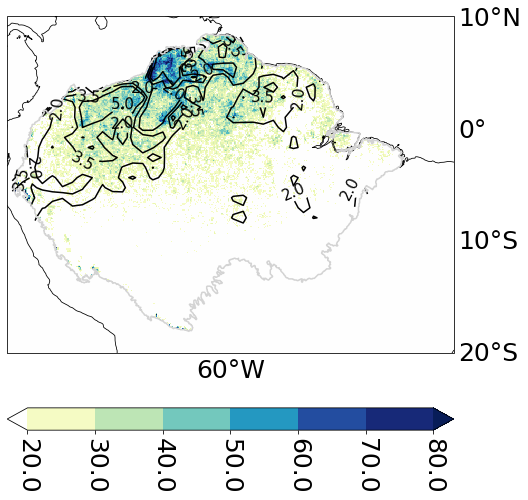

In [60]:
contourf(frequency_above_threshold_def_jas, diff_convg_dry, 20, 80, 7, 2, 5, 3, YlGnBu_new, 'both', '')

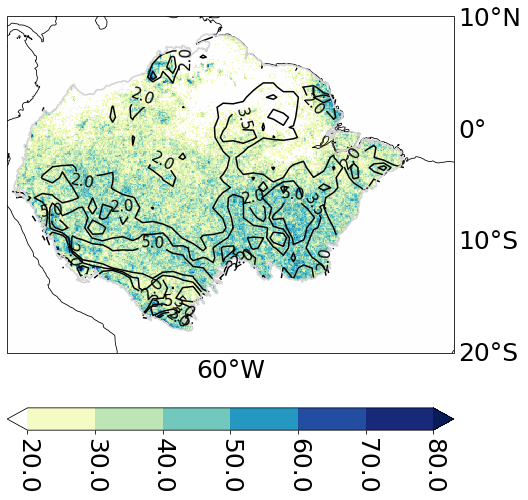

In [61]:
contourf(frequency_above_threshold_def_djf, diff_convg_wet, 20, 80, 7, 2, 5, 3, YlGnBu_new, 'both', '')

In [89]:
cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

In [91]:
right

(0.15294117647058825, 0.39215686274509803, 0.09803921568627451, 1.0)

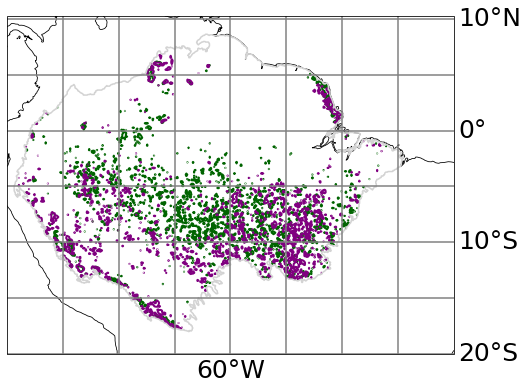

In [93]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

# Assuming 'data' is your xarray DataArray with dimensions (lat, lon)
# Example: data = xr.open_dataset('your_dataset.nc')['variable_name']
data_ctl = frequency_above_threshold_ctl_djf
data_def = frequency_above_threshold_def_djf

# Create the plot with Cartopy
fig = plt.figure(figsize=[8,10],facecolor='w')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ax.set_extent([-80,-40,-19,10])
ax.coastlines('50m',linewidth=0.8)
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
# manipulate `gridliner` object
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.ylines = False
# Plot the filled contour (values as colors)
cmap = 'YlGnBu'  # Use the colormap that fits your data
#contour_filled = plt.contourf(data_ctl.lon, data_ctl.lat, data_ctl, cmap=cmap, levels=20, transform=ccrs.PlateCarree())

# Add a colorbar
#plt.colorbar(contour_filled, orientation="horizontal", fraction=0.05, pad=0.10)

# Add contour lines for specific values
# Define specific levels or ranges based on the values you want to highlight
contour_lines_ctl = plt.contour(data_ctl.lon, data_ctl.lat, data_ctl, colors='darkgreen', linewidths=2, levels=[50], transform=ccrs.PlateCarree())
contour_lines_def = plt.contour(data_def.lon, data_def.lat, data_def, colors='purple', linewidths=2, levels=[50], transform=ccrs.PlateCarree())

# Add contour labels if desired
#plt.clabel(contour_lines_ctl, inline=True, fontsize=8)
#plt.clabel(contour_lines_ctl, inline=True, fontsize=8)

# Add gridlines
gl = ax.gridlines(draw_labels=False, linewidth=1.5, color='gray', crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

kw = {'levels':[-1], 'colors':['lightgrey'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                ax=ax,
                transform=ccrs.PlateCarree(),
                **kw
                )
#bounds = np.linspace(vmin, vmax, 11)
#cb = plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
#cb.ax.tick_params(labelsize=25)
#cb.ax.set_xticklabels(bounds,rotation=270)
# Show the plot
plt.show()


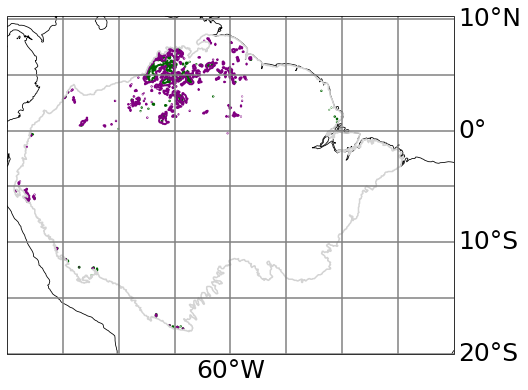

In [95]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

# Assuming 'data' is your xarray DataArray with dimensions (lat, lon)
# Example: data = xr.open_dataset('your_dataset.nc')['variable_name']
data_ctl = frequency_above_threshold_ctl_jas
data_def = frequency_above_threshold_def_jas

# Create the plot with Cartopy
fig = plt.figure(figsize=[8,10],facecolor='w')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ax.set_extent([-80,-40,-19,10])
ax.coastlines('50m',linewidth=0.8)
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
# manipulate `gridliner` object
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.ylines = False
# Plot the filled contour (values as colors)
cmap = 'YlGnBu'  # Use the colormap that fits your data
#contour_filled = plt.contourf(data_ctl.lon, data_ctl.lat, data_ctl, cmap=cmap, levels=20, transform=ccrs.PlateCarree())

# Add a colorbar
#plt.colorbar(contour_filled, orientation="horizontal", fraction=0.05, pad=0.10)

# Add contour lines for specific values
# Define specific levels or ranges based on the values you want to highlight
contour_lines_ctl = plt.contour(data_ctl.lon, data_ctl.lat, data_ctl, colors='darkgreen', linewidths=2, levels=[70], transform=ccrs.PlateCarree())
contour_lines_def = plt.contour(data_def.lon, data_def.lat, data_def, colors='purple', linewidths=2, levels=[70], transform=ccrs.PlateCarree())

# Add contour labels if desired
#plt.clabel(contour_lines_ctl, inline=True, fontsize=8)
#plt.clabel(contour_lines_ctl, inline=True, fontsize=8)

# Add gridlines
gl = ax.gridlines(draw_labels=False, linewidth=1.5, color='gray', crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

kw = {'levels':[-1], 'colors':['lightgrey'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                ax=ax,
                transform=ccrs.PlateCarree(),
                **kw
                )
#bounds = np.linspace(vmin, vmax, 11)
#cb = plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
#cb.ax.tick_params(labelsize=25)
#cb.ax.set_xticklabels(bounds,rotation=270)
# Show the plot
plt.show()